# Exploratory Data Analysis

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns

In [4]:
# YELP Dataset
# source: https://huggingface.co/datasets/yelp_review_full/viewer/yelp_review_full/train?f%5blabel%5d%5bvalue%5d=0
yelp = load_dataset('yelp_review_full')
yelp

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [5]:
#create dataset
train_ds = yelp['train']
train_ds[0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [6]:
train_ds.features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

<Axes: ylabel='count'>

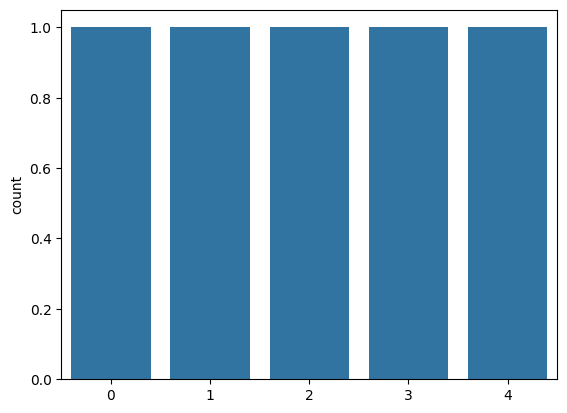

In [7]:
# imbalance of dataset
val_count = pd.DataFrame(train_ds['label']).value_counts()

sns.countplot(val_count.tolist())

<Axes: xlabel='label', ylabel='review_length'>

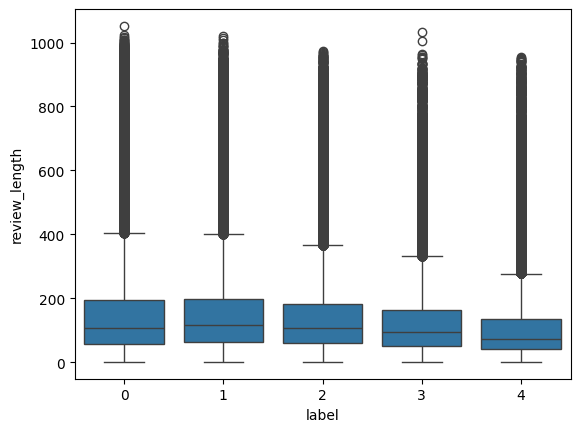

In [8]:
# understanding the texts
# count of words per review / per class
df_review_len_label = pd.DataFrame({'review_length': [len(s.split()) for s in train_ds['text']], 'label': train_ds['label']})
sns.boxplot(x='label', y='review_length', data=df_review_len_label)

# Simple Model

In [38]:
import numpy as np
import torch
from transformers import AutoModel, DistilBertTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
# create dataset
train_ds = yelp['train'].select(range(1000))

In [11]:
# Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
# Tokenizer
text = 'Hello, this is a sample sentence!'

encoded_text = tokenizer(text, return_tensors='pt')
encoded_text

{'input_ids': tensor([[ 101, 7592, 1010, 2023, 2003, 1037, 7099, 6251,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [18]:
# Tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'][0])

In [19]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] hello , this is a sample sentence ! [SEP]'

In [20]:
# how large is the vocabulary?
tokenizer.vocab_size

30522

In [21]:
# Max context length
max_context_length = tokenizer.model_max_length
max_context_length

512

In [22]:
# Function for tokenization
def tokenize_text(batch):
    # padding...texts are filled with zeros based to longest example
    # truncation...texts are cut off after max_context_length
    return tokenizer(batch['text'], return_tensors='pt', padding='max_length', truncation=True)

In [23]:
yelp_encodings = train_ds.map(tokenize_text, batched=True, batch_size=128)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [32]:
yelp_encodings.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])  # encodings need to be converted to torch tensors
def get_last_hidden_state(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # [:, 0] refers to CLS token for complete sentence representation
    return {'hidden_state': last_hidden_state[:, 0]}

In [33]:
yelp_hidden_states = yelp_encodings.map(get_last_hidden_state, batched=True, batch_size=128)  # will have additional column 'hidden_state'

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [34]:
yelp_hidden_states

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 1000
})

In [36]:
import joblib
joblib.dump(yelp_hidden_states, 'yelp_hidden_states.joblib')

['yelp_hidden_states.joblib']

In [39]:
cutoff = 800
X_train = np.array(yelp_hidden_states['hidden_state'][:cutoff])
y_train = np.array(yelp_hidden_states['label'][:cutoff])
X_test = np.array(yelp_hidden_states['hidden_state'][cutoff: ])
y_test = np.array(yelp_hidden_states['label'][cutoff: ])
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


X_train.shape: (800, 768), y_train.shape: (800,)
X_test.shape: (200, 768), y_test.shape: (200,)


In [40]:
# Dummy model
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)


0.165

In [41]:
# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.395

In [42]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.43

In [43]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.33

# Finetuning with HF Trainer

In [2]:
from transformers import AutoModelForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import DatasetDict

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier

In [3]:
# dataset
yelp_hidden_states = joblib.load('yelp_hidden_states.joblib')

In [19]:
# Model and Tokenizer
model_name = 'distilbert-base-uncased'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)


In [20]:
# Dataset
train_ds = yelp_hidden_states.select(range(0, 800))
eval_ds = yelp_hidden_states.select(range(800, 1000))
print(train_ds[0]['input_ids'].shape)
print(eval_ds[0]['input_ids'].shape)
print(yelp_hidden_states[800]['input_ids'].shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])


In [21]:
# DatasetDict
yelp_ds_dict = DatasetDict({'train': train_ds, 'test':eval_ds})

In [52]:
!pip install transformers[torch] # you need to restart the session for the update to take effect!!!

In [23]:
# Trainer Arguments
batch_size = 8  # adapt BS to fit into memory
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    learning_rate=2e-5,              # learning rate
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    disable_tqdm=False,
    push_to_hub=False,
    save_strategy='epoch',
    log_level='error',
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs

)

In [24]:
# Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=yelp_ds_dict['train'], eval_dataset=yelp_ds_dict['test'])
trainer.train()

Step,Training Loss
500,1.264000
1000,0.308400


TrainOutput(global_step=1000, training_loss=0.7862218475341797, metrics={'train_runtime': 448.1437, 'train_samples_per_second': 17.851, 'train_steps_per_second': 2.231, 'total_flos': 1059795886080000.0, 'train_loss': 0.7862218475341797, 'epoch': 10.0})

In [25]:
# get losses
trainer.evaluate()

{'eval_loss': 1.5897401571273804,
 'eval_runtime': 3.2379,
 'eval_samples_per_second': 61.769,
 'eval_steps_per_second': 7.721,
 'epoch': 10.0}

In [26]:
# calculate predictions
preds = trainer.predict(yelp_ds_dict['test'])

In [27]:
preds.metrics

{'test_loss': 1.5897401571273804,
 'test_runtime': 3.2698,
 'test_samples_per_second': 61.166,
 'test_steps_per_second': 7.646}

In [28]:
np.argmax(preds.predictions, axis=1)

array([0, 1, 4, 4, 3, 3, 3, 3, 3, 2, 4, 4, 4, 1, 3, 1, 3, 3, 2, 1, 0, 2,
       2, 1, 2, 2, 3, 1, 0, 3, 1, 2, 2, 2, 2, 3, 3, 4, 2, 2, 3, 4, 3, 3,
       1, 1, 4, 4, 4, 2, 4, 4, 4, 2, 2, 4, 4, 1, 3, 4, 1, 4, 2, 2, 1, 2,
       4, 0, 4, 1, 4, 4, 2, 2, 1, 0, 1, 3, 1, 3, 1, 1, 3, 1, 2, 2, 2, 1,
       1, 3, 4, 2, 3, 1, 1, 2, 1, 2, 4, 2, 1, 1, 1, 2, 4, 1, 1, 1, 0, 3,
       1, 2, 3, 3, 3, 3, 1, 1, 3, 2, 4, 3, 0, 3, 3, 2, 3, 1, 3, 2, 4, 4,
       3, 4, 0, 1, 2, 4, 1, 4, 0, 1, 4, 3, 0, 4, 4, 1, 2, 4, 4, 3, 3, 1,
       2, 2, 1, 4, 2, 3, 4, 1, 3, 1, 0, 1, 4, 1, 0, 2, 2, 3, 4, 4, 4, 2,
       0, 0, 1, 1, 1, 1, 0, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       2, 4])

<Axes: >

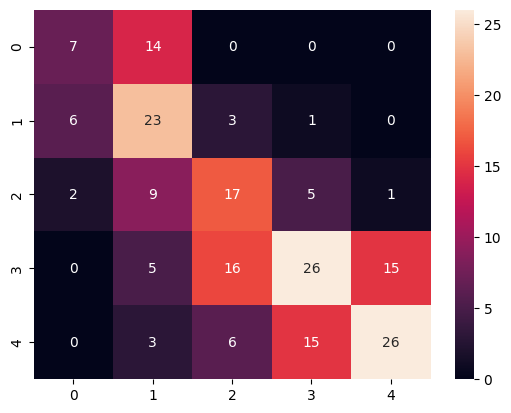

In [29]:
# confusion matrix
true_classes = yelp_ds_dict['test']['label']
preds_classes = np.argmax(preds.predictions, axis=1)
conf_mat = confusion_matrix(true_classes, preds_classes)
sns.heatmap(conf_mat, annot=True)

In [30]:
# accuracy
accuracy_score(true_classes, preds_classes)

0.495

In [31]:
# baseline classifier training

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(yelp_ds_dict['train']['label'], yelp_ds_dict['train']['label'])

DummyClassifier(strategy='most_frequent')

In [32]:
# baseline classifier accuracy
dummy_clf.score(yelp_ds_dict['test']['label'], yelp_ds_dict['test']['label'])

0.165

In [49]:
# Define the function to move tensors to the device
def move_to_device(batch):
    return {k: v.to(device) for k, v in batch.items() if torch.is_tensor(v)}

# Apply the function to each split in the DatasetDict
yelp_ds_dict = yelp_ds_dict.map(move_to_device, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [50]:
# Inference: inspect individual reviews
with torch.no_grad():
    outputs = model(yelp_ds_dict['test']['input_ids'], yelp_ds_dict['test']['attention_mask'])

In [51]:
# Loss calculation
pred_labels = torch.argmax(outputs.logits, dim=1)
loss = cross_entropy(outputs.logits, yelp_ds_dict['test']['label'], reduction='none')

In [53]:
df_individual_reviews = pd.DataFrame({'text': yelp_ds_dict['test']['text'], 'label': yelp_ds_dict['test']['label'], 'pred_label': pred_labels, 'loss': loss}).sort_values('loss', ascending=False).reset_index(drop=True)
df_individual_reviews


,text,label,pred_label,loss
0,This place has steadily improved over the year...,3,1,6.418419
1,"My husband and I stopped going here, back in 2...",4,1,6.003139
2,I was somewhat worried about going here since ...,4,2,5.497118
3,"Food is tasty, though portions are for the wai...",2,0,5.450728
4,i was super excited to try quiet storm when i ...,1,3,5.399344
...,...,...,...,...
195,I was underwhelmed with our dining experience....,1,1,0.020952
196,Cafe Zinho is a cute little restaurant tucked ...,1,1,0.019751
197,"Why do vegetarian restaurants think we need \""...",1,1,0.017890
198,The blonde woman who tuns the gym was extremel...,0,0,0.014625


<Axes: xlabel='label', ylabel='loss'>

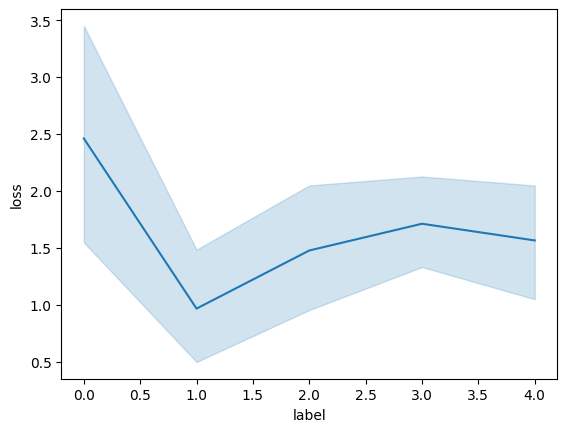

In [54]:
sns.lineplot(data=df_individual_reviews, x='label', y='loss')


In [ ]:
# save the model
# login via Terminal: huggingface-cli login
# create Token in HuggingFace Account

In [67]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write)

In [61]:
from huggingface_hub import create_repo

In [76]:
create_repo('amyang176/results')

RepoUrl('https://huggingface.co/amyang176/results', endpoint='https://huggingface.co', repo_type='model', repo_id='amyang176/results')

In [77]:
# Push the model to HuggingFace Hub
trainer.create_model_card(model_name = 'distilbert-base-uncased-yelp')
trainer.push_to_hub(commit_message='Yelp review classification')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/amyang176/results/commit/b4d640bba9a7ec1c5028b05a1f51370f3e7bd920', commit_message='Yelp review classification', commit_description='', oid='b4d640bba9a7ec1c5028b05a1f51370f3e7bd920', pr_url=None, pr_revision=None, pr_num=None)

In [78]:
# load model from HuggingFace Hub
# name was changed online to distilbert-base-uncased-yelp
from transformers import pipeline
model_id = 'BertGollnick/distilbert-base-uncased-yelp-new'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
classifier = pipeline('sentiment-analysis', model=model_id, tokenizer=tokenizer)

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<Axes: xlabel='label', ylabel='score'>

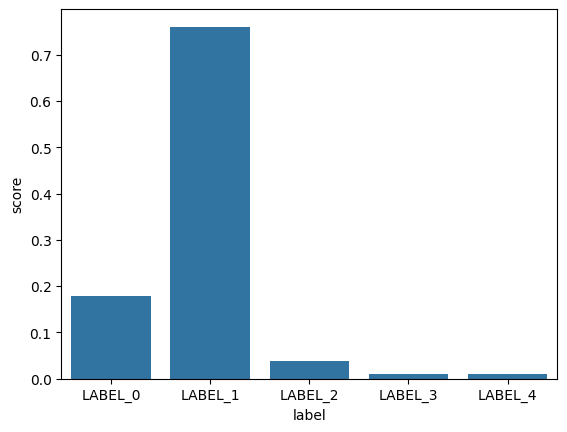

In [79]:
# visualise scores
res = classifier('it is not so great', return_all_scores=True)[0]
df_res = pd.DataFrame(res)
sns.barplot(data=df_res, x='label', y='score')